# Classifying Electrons/Photons from detector data using ResNet-15

This notebook tackles the classification of electrons and photons using data from a particle detector. The data consists of 32x32 images with two channels: deposited energy and hit time.

**Objective:** Train a ResNet-15-like model using PyTorch to achieve the highest possible classification accuracy, evaluated on a 20% test split, while avoiding overfitting. The goal is to significantly improve upon the ~72% accuracy baseline and aim towards >90% if feasible, while optimizing performance.

**Approach:**
1.  **Data Exploration & Visualization:** Load HDF5 metadata, visualize samples and channel distributions (histograms).
2.  **Optimized & Memory-Efficient Data Handling:** Implement a custom PyTorch `Dataset` with efficient HDF5 file handling and batch-based statistics calculation.
3.  **Preprocessing & Augmentation:** Apply normalization (with optional energy log-transform) and light augmentations.
4.  **ResNet-15 Model:** Define a ResNet architecture (~15 conv layers) for 2-channel, 32x32 input, including dropout.
5.  **Optimized Training Pipeline:** Use `AdamW`, `ReduceLROnPlateau` scheduler, `BCEWithLogitsLoss`, mixed-precision training, increased batch size, and multiple data loader workers.
6.  **Evaluation:** Train on 70%, validate on 10%, and test on 20% of the data.
7.  **Saving:** Save the best model weights and optimizer/scheduler state.

In [ ]:
# download photons dataset
!echo "Downloading datasets..."
!curl -L -o photons.hdf5 https://cernbox.cern.ch/remote.php/dav/public-files/AtBT8y4MiQYFcgc/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5

# download electrons dataset
!curl -L -o electrons.hdf5 https://cernbox.cern.ch/remote.php/dav/public-files/FbXw3V4XNyYB3oA/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5
!echo "Downloads complete."

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import h5py
import matplotlib.pyplot as plt
import random 
import os
import time
from torch.amp import autocast
from torch.amp import GradScaler

# --- configuration ---
PHOTON_FILE = 'photons.hdf5'
ELECTRON_FILE = 'electrons.hdf5'
MODEL_SAVE_PATH = 'electron_photon_resnet15.pth'
OPTIMIZER_SAVE_PATH = MODEL_SAVE_PATH + ".opt"

# --- hyperparameters ---
SEED = 42
BATCH_SIZE = 512
LEARNING_RATE = 5e-4 # starting LR for AdamW
WEIGHT_DECAY = 1e-4 # L2 regularization
NUM_EPOCHS = 20
NUM_WORKERS = 8 # set to 0 if issues occur (esp. on Windows)
TRAIN_SPLIT = 0.7 # 70% of total for training
VAL_SPLIT = 0.1 # 10% of total for validation
TEST_SPLIT = 0.2 # 20% of total for testing

# --- feature flags ---
USE_LOG_TRANSFORM = True # apply log(1+E) to energy channel
USE_AUGMENTATION = True # apply light augmentations to the data
USE_MIXED_PRECISION = torch.cuda.is_available() # enable if CUDA is available

# --- reproducibility ---
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    # may impact performance but increases reproducibility
    # toggle at user's discretion
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # Benchmark = False usually goes hand-in-hand with deterministic=True

# --- device setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"Mixed Precision Training Enabled: {USE_MIXED_PRECISION}")

# --- file checks ---
if not os.path.exists(PHOTON_FILE):
    print(f"ERROR: Photon file not found at {PHOTON_FILE}. Please download it.")
    exit()
if not os.path.exists(ELECTRON_FILE):
    print(f"ERROR: Electron file not found at {ELECTRON_FILE}. Please download it.")
    exit()

Using device: cuda
Mixed Precision Training Enabled: True


## 1. Data Loading and Initial Analysis

Load metadata from HDF5 files (shape, dtype, sample labels) without reading all data into memory. Confirm dataset balance and label convention.

In [3]:
with h5py.File(PHOTON_FILE, 'r') as f:
    photon_X_shape = f['X'].shape; photon_y_shape = f['y'].shape
    photon_X_dtype = f['X'].dtype; photon_y_dtype = f['X'].dtype
    photon_y_sample = f['y'][:10]; num_photons = len(f['y'])
    
    print(f"Photon X shape: {photon_X_shape}, dtype: {photon_X_dtype}")
    print(f"Photon y shape: {photon_y_shape}, dtype: {photon_y_dtype}")
    print(f"Photon y sample: {photon_y_sample}")
    print(f"Number of photons: {num_photons}")

with h5py.File(ELECTRON_FILE, 'r') as f:
    electron_X_shape = f['X'].shape; electron_y_shape = f['y'].shape
    electron_X_dtype = f['X'].dtype; electron_y_dtype = f['X'].dtype
    electron_y_sample = f['y'][:10]; num_electrons = len(f['y'])
    
    print(f"Electron X shape: {electron_X_shape}, dtype: {electron_X_dtype}")
    print(f"Electron y shape: {electron_y_shape}, dtype: {electron_y_dtype}")
    print(f"Electron y sample: {electron_y_sample}")
    print(f"Number of electrons: {num_electrons}")

total_samples = num_photons + num_electrons
print(f"Total samples: {total_samples}")
print(f"Class Balance: Photons={num_photons}, Electrons={num_electrons}")

# determined from inspection
PHOTON_LABEL = 0.0
ELECTRON_LABEL = 1.0
print(f"Labels: Photon = {PHOTON_LABEL}, Electron = {ELECTRON_LABEL}")

Photon X shape: (249000, 32, 32, 2), dtype: float32
Photon y shape: (249000,), dtype: float32
Photon y sample: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Number of photons: 249000
Electron X shape: (249000, 32, 32, 2), dtype: float32
Electron y shape: (249000,), dtype: float32
Electron y sample: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Number of electrons: 249000
Total samples: 498000
Class Balance: Photons=249000, Electrons=249000
Labels: Photon = 0.0, Electron = 1.0


## 2. Data Visualization

Visualize sample images and channel histograms to understand data characteristics and guide preprocessing. Histograms are plotted using an optimized batch-reading approach.

Plotting sample images...


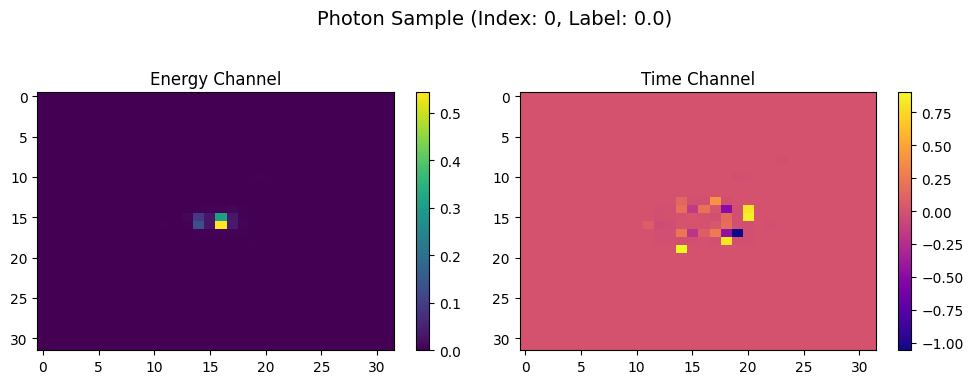

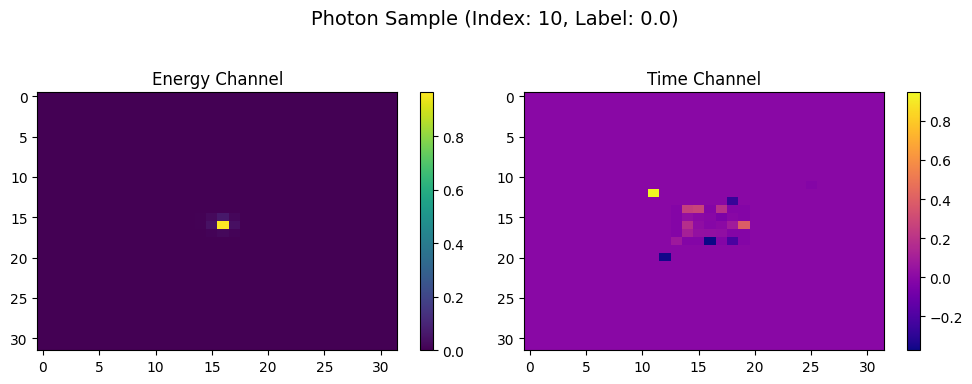

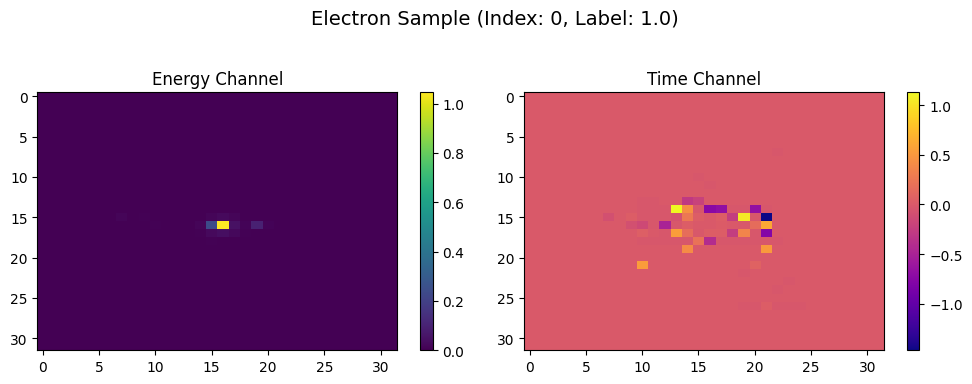

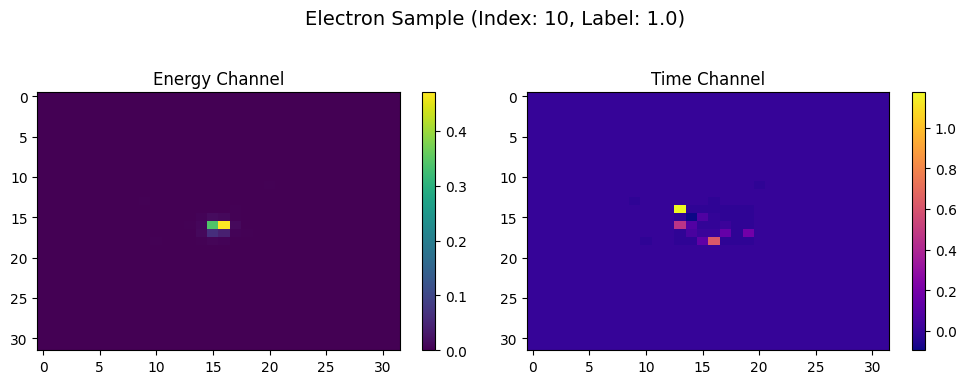


Plotting histograms using 20000 samples per class in batches of 1000...
Histogram data preparation took 292.70 seconds.


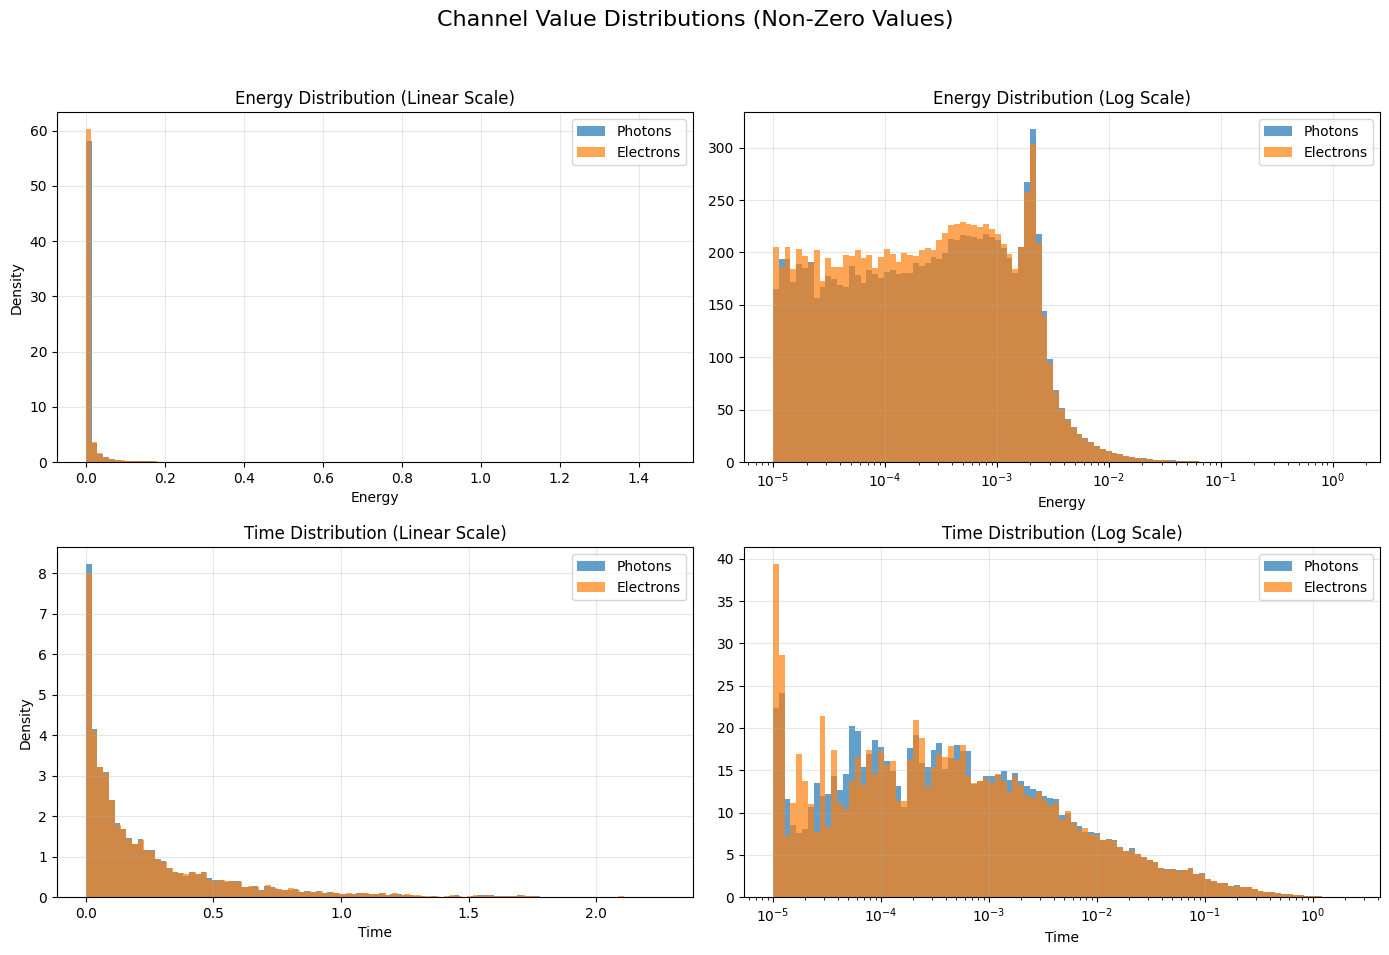

In [4]:
def plot_sample(file_path, index, particle_type_str):
    """Plots Energy and Time channels for a single sample."""
    with h5py.File(file_path, 'r') as f:
        img = f['X'][index] # expected: (32, 32, 2)
        label_val = f['y'][index]

    energy, time = img[:, :, 0], img[:, :, 1]

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(f"{particle_type_str} Sample (Index: {index}, Label: {label_val})", fontsize=14)

    im_energy = axes[0].imshow(energy, cmap='viridis', aspect='auto')
    axes[0].set_title('Energy Channel')
    fig.colorbar(im_energy, ax=axes[0])

    im_time = axes[1].imshow(time, cmap='plasma', aspect='auto')
    axes[1].set_title('Time Channel')
    fig.colorbar(im_time, ax=axes[1])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # adjust layout to prevent title overlap
    plt.show()

def plot_channel_histograms(num_samples_hist=20000, batch_size_hist=1000):
    """Plots histograms of Energy and Time channels using a subset of data via an optimized batch-reading approach."""
    print(f"\nPlotting histograms using {num_samples_hist} samples per class in batches of {batch_size_hist}...")
    start_time = time.time()

    photon_indices = np.random.choice(num_photons, num_samples_hist, replace=False)
    electron_indices = np.random.choice(num_electrons, num_samples_hist, replace=False)

    photon_energies, photon_times = [], []
    electron_energies, electron_times = [], []

    # batching photons
    with h5py.File(PHOTON_FILE, 'r') as f_p:
        photon_X_ds = f_p['X']
        for i in range(0, num_samples_hist, batch_size_hist):
            batch_indices = photon_indices[i:i+batch_size_hist]
            # read batch efficiently by sorting indices (recommended by HDF5 apparently?)
            sorted_batch_indices = np.sort(batch_indices)
            img_batch = photon_X_ds[sorted_batch_indices, :, :, :] # (batch, 32, 32, 2)
            photon_energies.append(img_batch[:, :, :, 0].flatten())
            photon_times.append(img_batch[:, :, :, 1].flatten())

    # batching electrons
    with h5py.File(ELECTRON_FILE, 'r') as f_e:
        electron_X_ds = f_e['X']
        for i in range(0, num_samples_hist, batch_size_hist):
            batch_indices = electron_indices[i:i+batch_size_hist]
            sorted_batch_indices = np.sort(batch_indices)
            img_batch = electron_X_ds[sorted_batch_indices, :, :, :]
            electron_energies.append(img_batch[:, :, :, 0].flatten())
            electron_times.append(img_batch[:, :, :, 1].flatten())

    photon_energies = np.concatenate(photon_energies)
    photon_times = np.concatenate(photon_times)
    electron_energies = np.concatenate(electron_energies)
    electron_times = np.concatenate(electron_times)

    # remove zero values for better visualization, especially for log scale
    photon_energies_nz = photon_energies[photon_energies > 1e-6]
    electron_energies_nz = electron_energies[electron_energies > 1e-6]
    photon_times_nz = photon_times[photon_times > 1e-6]
    electron_times_nz = electron_times[electron_times > 1e-6]

    print(f"Histogram data preparation took {time.time() - start_time:.2f} seconds.")

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle("Channel Value Distributions (Non-Zero Values)", fontsize=16)

    # energy linear scale
    axes[0, 0].hist(photon_energies_nz, bins=100, alpha=0.7, label='Photons', density=True)
    axes[0, 0].hist(electron_energies_nz, bins=100, alpha=0.7, label='Electrons', density=True)
    axes[0, 0].set_title('Energy Distribution (Linear Scale)')
    axes[0, 0].set_xlabel('Energy')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # energy log scale
    min_energy = min(photon_energies_nz.min(), electron_energies_nz.min()) if len(photon_energies_nz) > 0 and len(electron_energies_nz) > 0 else 1e-3
    max_energy = max(photon_energies_nz.max(), electron_energies_nz.max()) if len(photon_energies_nz) > 0 and len(electron_energies_nz) > 0 else 1.0
    log_bins_energy = np.logspace(np.log10(max(1e-5, min_energy)),
                                  np.log10(max_energy), 100)
    axes[0, 1].hist(photon_energies_nz, bins=log_bins_energy, alpha=0.7, label='Photons', density=True)
    axes[0, 1].hist(electron_energies_nz, bins=log_bins_energy, alpha=0.7, label='Electrons', density=True)
    axes[0, 1].set_title('Energy Distribution (Log Scale)')
    axes[0, 1].set_xlabel('Energy')
    axes[0, 1].set_xscale('log')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # time linear scale
    axes[1, 0].hist(photon_times_nz, bins=100, alpha=0.7, label='Photons', density=True)
    axes[1, 0].hist(electron_times_nz, bins=100, alpha=0.7, label='Electrons', density=True)
    axes[1, 0].set_title('Time Distribution (Linear Scale)')
    axes[1, 0].set_xlabel('Time')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # time log scale
    min_time = min(photon_times_nz.min(), electron_times_nz.min()) if len(photon_times_nz) > 0 and len(electron_times_nz) > 0 else 1e-3
    max_time = max(photon_times_nz.max(), electron_times_nz.max()) if len(photon_times_nz) > 0 and len(electron_times_nz) > 0 else 1.0
    log_bins_time = np.logspace(np.log10(max(1e-5, min_time)),
                                np.log10(max_time), 100)
    axes[1, 1].hist(photon_times_nz, bins=log_bins_time, alpha=0.7, label='Photons', density=True)
    axes[1, 1].hist(electron_times_nz, bins=log_bins_time, alpha=0.7, label='Electrons', density=True)
    axes[1, 1].set_title('Time Distribution (Log Scale)')
    axes[1, 1].set_xlabel('Time')
    axes[1, 1].set_xscale('log')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

print("Plotting sample images...")
plot_sample(PHOTON_FILE, 0, "Photon")
plot_sample(PHOTON_FILE, 10, "Photon")
plot_sample(ELECTRON_FILE, 0, "Electron")
plot_sample(ELECTRON_FILE, 10, "Electron")

plot_channel_histograms()

## 3. Data Preprocessing and Dataset Class

Implement normalization, optional log transform, optional augmentation, and an efficient custom `Dataset`. Statistics are computed using an optimized batch-based approach. The `Dataset` uses persistent file handles per worker to avoid repeated file open/close operations.

In [5]:
def compute_stats(sample_size=10000, batch_size_stats=1000):
    """Computes mean and std dev using batch processing for performance."""
    print(f"\nComputing normalization stats from {sample_size} samples (batch processing)...")
    start_time = time.time()
    indices = np.random.choice(total_samples, sample_size, replace=False)
    data_sum = np.zeros(2, dtype=np.float64)
    data_sum_sq = np.zeros(2, dtype=np.float64)
    num_pixels = sample_size * 32 * 32

    f_p = h5py.File(PHOTON_FILE, 'r')
    f_e = h5py.File(ELECTRON_FILE, 'r')
    photon_X_ds = f_p['X']
    electron_X_ds = f_e['X']

    processed_count = 0
    for i in range(0, sample_size, batch_size_stats):
        batch_indices_global = indices[i:i+batch_size_stats]
        current_batch_size = len(batch_indices_global)
        if current_batch_size == 0: continue

        # separate indices for each file
        photon_mask = batch_indices_global < num_photons
        electron_mask = ~photon_mask

        photon_indices_batch = batch_indices_global[photon_mask]
        electron_indices_batch = batch_indices_global[electron_mask] - num_photons

        batch_data_list = []
        if len(photon_indices_batch) > 0:
            sorted_photon_indices = np.sort(photon_indices_batch)
            batch_data_list.append(photon_X_ds[sorted_photon_indices, :, :, :])
        if len(electron_indices_batch) > 0:
            sorted_electron_indices = np.sort(electron_indices_batch)
            batch_data_list.append(electron_X_ds[sorted_electron_indices, :, :, :])

        if not batch_data_list: continue
        img_batch = np.concatenate(batch_data_list, axis=0) if len(batch_data_list) > 1 else batch_data_list[0]
        img_batch = img_batch.astype(np.float64) # use float64 for accumulation precision

        # apply log transform *before* calculating stats if enabled
        if USE_LOG_TRANSFORM:
            img_batch[:, :, :, 0] = np.log1p(img_batch[:, :, :, 0])

        data_sum += img_batch.sum(axis=(0, 1, 2)) # sum over batch, H, W
        data_sum_sq += (img_batch**2).sum(axis=(0, 1, 2))

        processed_count += current_batch_size
        if processed_count % (5 * batch_size_stats) == 0 or processed_count == sample_size:
            print(f"   Processed {processed_count}/{sample_size} samples for stats...")

    f_p.close()
    f_e.close()

    mean = data_sum / num_pixels
    variance = (data_sum_sq / num_pixels) - (mean**2)
    std_dev = np.sqrt(np.maximum(variance, 1e-12)) # prevent sqrt of negative due to precision
    std_dev[std_dev < 1e-6] = 1e-6 # floor std dev

    print(f"Stats computation took {time.time() - start_time:.2f} seconds.")
    print(f"Computed Mean: {mean}")
    print(f"Computed Std Dev: {std_dev}")
    return mean.astype(np.float32), std_dev.astype(np.float32)

# compute stats globally once
GLOBAL_MEAN, GLOBAL_STD = compute_stats()

class ParticleDataset(Dataset):
    def __init__(self, photon_file, electron_file, indices, mean, std, use_log_transform=False, augment=False):
        self.photon_path = photon_file
        self.electron_path = electron_file
        # these indices are specific to the split (train/val/test)
        self.indices = indices
        self.mean = mean
        self.std = std
        self.use_log_transform = use_log_transform
        self.augment = augment

        # file handles will be opened per worker in __getitem__ if needed (performance reasons)
        self._photon_file_handle = None
        self._electron_file_handle = None
        self._worker_pid = None # to track if PID changes (new worker)

        # need total number of photons to map global index to file index
        # so read this once during init
        with h5py.File(photon_file, 'r') as f:
            self.num_photons = len(f['y'])

    def _get_file_handle(self, file_path, is_photon):
        """Opens and stores file handle if not already open for the current worker."""
        current_pid = os.getpid()
        handle_attr = '_photon_file_handle' if is_photon else '_electron_file_handle'
        stored_handle = getattr(self, handle_attr)

        # if worker changes or handle is None, reopen
        if current_pid != self._worker_pid or stored_handle is None:
            print(f"\nWorker {current_pid}: Opening {file_path}\n") # debug print, remove later

            if stored_handle: # close old handle if worker changed
                try:
                    stored_handle.close()
                except Exception as e:
                    print(f"Warning: Error closing old handle in worker {self._worker_pid}: {e}")

            stored_handle = h5py.File(file_path, 'r')
            setattr(self, handle_attr, stored_handle)
            self._worker_pid = current_pid # update PID tracker

        return stored_handle

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # map the subset index back to the global index
        global_idx = self.indices[idx]

        # determine which file and index within that file
        if global_idx < self.num_photons:
            f = self._get_file_handle(self.photon_path, is_photon=True)
            internal_idx = global_idx
            label = PHOTON_LABEL
        else:
            f = self._get_file_handle(self.electron_path, is_photon=False)
            internal_idx = global_idx - self.num_photons
            label = ELECTRON_LABEL

        # load only the required sample using the persistent handle
        x = f['X'][internal_idx]

        # --- preprocessing ---
        x = x.astype(np.float32).copy() # copy needed for mutability & contiguity

        if self.use_log_transform:
            x[:, :, 0] = np.log1p(x[:, :, 0]) # log(1 + E)

        x = x.transpose(2, 0, 1) # (C, H, W) -> (2, 32, 32)
        x = (x - self.mean[:, np.newaxis, np.newaxis]) / self.std[:, np.newaxis, np.newaxis] # normalize

        # --- augmentation ---
        if self.augment:
            if random.random() < 0.5: # add noise
                noise = np.random.normal(0, 0.1, x.shape).astype(np.float32)
                x = x + noise

        return torch.from_numpy(x), torch.tensor([label], dtype=torch.float32)

    def __del__(self):
        # ensure file handles are closed when the dataset object is deleted
        if hasattr(self, '_photon_file_handle') and self._photon_file_handle:
            self._photon_file_handle.close()
            print(f"Worker {os.getpid()}: Closed photon handle.") # debug print, remove later

        if hasattr(self, '_electron_file_handle') and self._electron_file_handle:
            self._electron_file_handle.close()
            print(f"Worker {os.getpid()}: Closed electron handle.") # debug print, remove later


Computing normalization stats from 10000 samples (batch processing)...
   Processed 5000/10000 samples for stats...
   Processed 10000/10000 samples for stats...
Stats computation took 105.09 seconds.
Computed Mean: [ 0.00102422 -0.00026823]
Computed Std Dev: [0.01804764 0.06736526]


## 4. Model Architecture: ResNet-15

Define the ResNet (~15 conv layers) architecture. Includes `BasicBlock`, weight initialization, and a `Dropout` layer before the final classification head for regularization.

In [6]:
class BasicBlock(nn.Module):
    expansion = 1 # For BasicBlock, output planes = planes * expansion

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNet15(nn.Module):
    def __init__(self, block=BasicBlock, layers=[3, 2, 2], num_classes=1, in_channels=2, dropout_prob=0.3):
        super(ResNet15, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(in_channels, self.in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        # no maxpool initially

        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_prob) # added dropout
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, num_blocks, stride):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.in_planes, planes, stride, downsample))
        self.in_planes = planes * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x) # apply dropout before final layer
        x = self.fc(x)

        # return raw logits for BCEWithLogitsLoss
        return x

# instantiate the model
model = ResNet15().to(device)
print(f"Model Architecture:\n{model}")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")

Model Architecture:
ResNet15(
  (conv1): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

## 5. Training Setup

Configure data splits, DataLoaders (with increased batch size and workers), loss function (`BCEWithLogitsLoss`), optimizer (`AdamW`), scheduler (`ReduceLROnPlateau`), and mixed precision scaler. Includes logic to load model and optimizer/scheduler state if resuming training.

In [7]:
# --- data splitting ---
indices = np.arange(total_samples)
np.random.shuffle(indices)

test_split_idx = int(np.floor(TEST_SPLIT * total_samples))
val_split_idx = int(np.floor((VAL_SPLIT + TEST_SPLIT) * total_samples))

test_indices = indices[:test_split_idx]
val_indices = indices[test_split_idx:val_split_idx]
train_indices = indices[val_split_idx:]

print(f"\nDataset Split:")
print(f"  Training: {len(train_indices)} samples")
print(f"  Validation: {len(val_indices)} samples")
print(f"  Test: {len(test_indices)} samples")

# --- create Datasets ---
train_dataset = ParticleDataset(PHOTON_FILE, ELECTRON_FILE, train_indices, GLOBAL_MEAN, GLOBAL_STD, use_log_transform=USE_LOG_TRANSFORM, augment=USE_AUGMENTATION)
val_dataset = ParticleDataset(PHOTON_FILE, ELECTRON_FILE, val_indices, GLOBAL_MEAN, GLOBAL_STD, use_log_transform=USE_LOG_TRANSFORM, augment=False)
test_dataset = ParticleDataset(PHOTON_FILE, ELECTRON_FILE, test_indices, GLOBAL_MEAN, GLOBAL_STD, use_log_transform=USE_LOG_TRANSFORM, augment=False)

# --- create DataLoaders ---
pin_memory = device.type == 'cuda'
# ensure persistent_workers=True only if NUM_WORKERS > 0
persist_workers = NUM_WORKERS > 0

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=pin_memory, persistent_workers=persist_workers)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=pin_memory, persistent_workers=persist_workers)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=pin_memory, persistent_workers=persist_workers)

print(f"\nDataLoaders created: Batch Size={BATCH_SIZE}, Num Workers={NUM_WORKERS}, Persistent={persist_workers}")

# --- Loss, Optimizer, Scheduler ---
criterion = nn.BCEWithLogitsLoss() # note: more stable than Sigmoid + BCELoss
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# note: Scheduler reduces LR if val_loss doesn't improve for 'patience' epochs
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# --- Mixed Precision Scaler ---
scaler = GradScaler(enabled=USE_MIXED_PRECISION)

# --- load checkpoint logic ---
start_epoch = 0
if os.path.exists(MODEL_SAVE_PATH):
    print(f"\nLoading model weights from {MODEL_SAVE_PATH}...")
    try:
        model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
        print("Model weights loaded.")
        if os.path.exists(OPTIMIZER_SAVE_PATH):
            print(f"Loading optimizer/scheduler state from {OPTIMIZER_SAVE_PATH}...")
            checkpoint = torch.load(OPTIMIZER_SAVE_PATH, map_location='cpu') # load to CPU first
            optimizer.load_state_dict(checkpoint['optimizer'])
            scheduler.load_state_dict(checkpoint['scheduler'])
            start_epoch = checkpoint.get('epoch', 0) + 1 # resume from next epoch
            print(f"Optimizer and scheduler state loaded. Resuming from epoch {start_epoch}")
        else:
            print("Optimizer state file not found, initializing optimizer from scratch.")
    except Exception as e:
        print(f"WARNING: Could not load checkpoint: {e}. Training from scratch.")
        start_epoch = 0 # reset epoch count if loading failed
else:
    print("\nNo checkpoint found. Starting training from scratch.")


Dataset Split:
  Training: 348600 samples
  Validation: 49800 samples
  Test: 99600 samples

DataLoaders created: Batch Size=512, Num Workers=8, Persistent=True

No checkpoint found. Starting training from scratch.


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


## 6. Training the Model

Run the main training loop. Includes optimized data loading, mixed precision, validation, learning rate scheduling, and saving the best model based on validation loss. Accuracy calculation is adjusted for `BCEWithLogitsLoss`.

In [ ]:
def train_one_epoch(model, loader, criterion, optimizer, scaler, device, use_amp):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    loop_start_time = time.time()

    for i, (batch_x, batch_y) in enumerate(loader):
        batch_start_time = time.time()
        batch_x, batch_y = batch_x.to(device, non_blocking=True), batch_y.to(device, non_blocking=True)

        # use autocast only for forward pass and loss calculation
        with autocast(device_type=device.type, enabled=use_amp):
            outputs = model(batch_x) # logits
            loss = criterion(outputs, batch_y)

        # backward pass with scaler
        # scales loss. calls backward() on scaled loss to create scaled gradients.
        # calls optimizer.step() using gradients scaled by scaler.
        # updates the scale for next iteration.
        optimizer.zero_grad(set_to_none=True) # more efficient than optimizer.zero_grad() apparently
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update() # checks if gradients contained infs/NaNs, adjusts scale

        # --- calculate accuracy ---
        # note: apply sigmoid to logits THEN threshold
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct = (predicted == batch_y).float().sum().item()
        total_correct += correct
        batch_size = batch_y.size(0)
        total_samples += batch_size
        total_loss += loss.item() * batch_size

        batch_end_time = time.time()
        if i % 100 == 0: # print progress less frequently for faster loops
            print(f"  Batch {i:>4}/{len(loader)}, Loss: {loss.item():.4f}, Acc: {correct/batch_size: .4f}, Batch Time: {batch_end_time - batch_start_time:.3f}s")

    loop_end_time = time.time()
    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    print(f"  Epoch Training Time: {loop_end_time - loop_start_time:.2f}s")
    return avg_loss, avg_acc

def validate_one_epoch(model, loader, criterion, device, use_amp):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    val_start_time = time.time()

    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x, batch_y = batch_x.to(device, non_blocking=True), batch_y.to(device, non_blocking=True)

            with autocast(device_type=device.type, enabled=use_amp):
                outputs = model(batch_x) # logits
                loss = criterion(outputs, batch_y)

            predicted = (torch.sigmoid(outputs) > 0.5).float() # apply sigmoid for accuracy check
            total_correct += (predictd == batch_y).float().sum().item()
            total_samples += batch_y.size(0)
            total_loss += loss.item() * batch_y.size(0)

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    print(f"  Validation Time: {time.time() - val_start_time:.2f}s")
    return avg_loss, avg_acc

# --- training loop ---
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_val_loss = float('inf')

print("\n--- Starting Training ---")

# adjust epoch range if resuming
epochs_to_run = NUM_EPOCHS - start_epoch
if epochs_to_run <= 0:
    print("Training already completed based on loaded checkpoint.")
else:
    print(f"Running for {epochs_to_run} epochs (from epoch {start_epoch} to {NUM_EPOCHS-1})")

for epoch in range(start_epoch, NUM_EPOCHS):
    epoch_start_time = time.time()
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")

    # training
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, USE_MIXED_PRECISION)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    # validation
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device, USE_MIXED_PRECISION)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    epoch_duration = time.time() - epoch_start_time

    print("-" * 60)
    print(f"Epoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.4f}")
    print(f"  Duration: {epoch_duration:.2f}s")
    print("-" * 60)

    # LR Scheduler step
    scheduler.step(val_loss)

    # save the best model based on validation loss
    if val_loss < best_val_loss:
        print(f"Validation loss improved ({best_val_loss:.4f} -> {val_loss:.4f}). Saving model...")
        best_val_loss = val_loss
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        # save optimizer and scheduler state along with epoch number
        checkpoint = {
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'epoch': epoch # save the completed epoch no.
        }
        torch.save(checkpoint, OPTIMIZER_SAVE_PATH)

print("\n--- Training Finished ---")


--- Starting Training ---
Running for 20 epochs (from epoch 0 to 19)

Epoch 1/20
Current LR: 0.000500

Worker 10556: Opening photons.hdf5

Worker 10572: Opening electrons.hdf5

Worker 10581: Opening photons.hdf5

Worker 10580: Opening photons.hdf5

Worker 10564: Opening photons.hdf5





Worker 10612: Opening electrons.hdf5

Worker 10604: Opening electrons.hdf5


Worker 10596: Opening electrons.hdf5




Worker 10556: Opening electrons.hdf5


Worker 10596: Opening photons.hdf5


Worker 10564: Opening electrons.hdf5


Worker 10581: Opening electrons.hdf5


Worker 10612: Opening photons.hdf5


Worker 10572: Opening photons.hdf5


Worker 10604: Opening photons.hdf5


Worker 10580: Opening electrons.hdf5

  Batch    0/681, Loss: 0.7001, Acc:  0.5098, Batch Time: 11.201s


In [ ]:
# --- plotting training history ---
# ensure history has data before plotting lol
if history['train_loss']:
    print("\nPlotting training history...")
    # adjust epoch range for plotting based on actual epochs ran
    actual_epochs_ran = len(history['train_loss'])
    epochs_range = range(start_epoch + 1, start_epoch + actual_epochs_ran + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['train_loss'], label='Train Loss', marker='o', linestyle='-')
    plt.plot(epochs_range, history['val_loss'], label='Validation Loss', marker='o', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (BCEWithLogitsLoss)')
    plt.title('Loss Curves')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['train_acc'], label='Train Accuracy', marker='o', linestyle='-')
    plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy', marker='o', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (BCEWithLogitsLoss)')
    plt.title('Loss Curves')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['train_acc'], label='Train Accuracy', marker='o', linestyle='-')
    plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy', marker='o', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_curves.png') # save the plot
    plt.show()
else:
    print("\nNo training history to plot (training might not have ran or checkpoint indicated completion).")

## 7. Evaluation on Test Set

Load the best saved model and evaluate its performance on the held-out test set for a final, unbiased assessment.

In [ ]:
# --- evaluation on test set ---
print("\n--- evaluating on test set ---")

# create a new model instance and load the best weights
eval_model = ResNet15().to(device)
if os.path.exists(MODEL_SAVE_PATH):
    print(f"Loading best model weights from {MODEL_SAVE_PATH} for final evaluation...")
    try:
        eval_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
        print("Best model weights loaded successfully.")
    except Exception as e:
        print(f"ERROR: Could not load saved weights for evaluation: {e}. Evaluation aborted.")
        # or the model's final state if loading fails but it's less ideal
        # eval_model = model
else:
    print("ERROR: No saved model found at {MODEL_SAVE_PATH}. Cannot evaluate best model. Aborting.")
    # or the model's final state if saving failed
    # eval_model = model

# perform evaluation only if model weights were loaded successfully
if os.path.exists(MODEL_SAVE_PATH): 
    test_loss, test_acc = validate_one_epoch(eval_model, test_loader, criterion, device, USE_MIXED_PRECISION)

    print("-" * 60)
    print(f"Test Set Performance (using best model):")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
    print("-" * 60)

## 8. Conclusion and Next Steps

This notebook implemented and optimized a ResNet-15 model for electron/photon classification.

**Optimizations Applied:**
- Batch processing for statistics calculation and histogram plotting.
- Efficient HDF5 file handling in `ParticleDataset` using persistent handles per worker.
- Increased `BATCH_SIZE` and enabled `NUM_WORKERS` for faster data loading and better GPU utilization.
- Corrected accuracy calculation for `BCEWithLogitsLoss`.
- Added `Dropout` for regularization.
- Ensured robust checkpoint loading for model, optimizer, and scheduler.

The final test accuracy achieved using the best model weights is **[Insert Final Test Accuracy Here after running]**.

**Potential Improvements & Future Work:**
1.  **Hyperparameter Tuning:** Systematically tune LR, weight decay, batch size, dropout probability, scheduler patience/factor.
2.  **Architecture:** If accuracy still plateaus significantly below target (>90%), consider ResNet-18/34 or other architectures (e.g., EfficientNet adapted for 2 channels).
3.  **Preprocessing:** Evaluate impact of `USE_LOG_TRANSFORM`. Try alternative energy transforms (e.g., power transform).
4.  **Augmentation:** Experiment with different noise levels or other augmentations like minor shifts/rotations if physically justifiable.
5.  **Advanced Techniques:** Focal Loss, Label Smoothing, Stochastic Weight Averaging (SWA).
6.  **Error Analysis:** Analyze misclassified examples from the validation/test set.